In [2]:
from HTML import config as Config
from HTML.dataset import *
from HTML.config import ratio, nominal, ordinal, meaningless
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
x_train = pd.read_csv(Config.train_path)
x_train.head()

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,-6.305161,0,0,Check-Out,2015-07-01
1,1,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,75.052227,0,0,Check-Out,2015-07-03
2,2,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,74.546401,0,0,Check-Out,2015-07-03
3,3,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,76.376288,0,0,Check-Out,2015-07-03
4,4,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,49.411647,0,0,Check-Out,2015-07-03


In [4]:
x_train.columns

Index(['ID', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [5]:
x_train['reservation_status'].value_counts()

Check-Out    58771
Canceled     31741
No-Show       1019
Name: reservation_status, dtype: int64

In [6]:
dummies = pd.get_dummies(
        data=x_train[set(x_train.columns) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled'}],
        columns=set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled'},
        drop_first=True,
        dummy_na=True)
dummies = dummies[sorted(set(dummies.columns) - {'index', 'ID'} - set(meaningless))]

In [7]:
x = dummies[sorted([c for c in dummies.columns if 'reservation_status' not in c])].to_numpy()
fact = pd.factorize(x_train['reservation_status'])
y = fact[0]

In [8]:
x.shape

(91531, 952)

In [9]:
y.shape

(91531,)

In [10]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [13]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

In [14]:
largest_class_weight_coef=np.max(np.bincount(y)) / len(y)
weights = CreateBalancedSampleWeights(y, largest_class_weight_coef=largest_class_weight_coef)

In [91]:
s = []
for i in [1,5,10,50,100,500,1000]:
    clf = XGBClassifier(
        objective='multi:softmax',
        n_estimators=10,
        learning_rate=.3,
        max_depth=6,
        subsample=.3,
        n_jobs=6,
        colsample_bytree=.9,
        random_state=1126,
        gamma=10,
        weights=weights
    )
    scores = cross_val_score(clf, x, y, cv=5, scoring='f1_macro', verbose=1, n_jobs=2)
    s.append(scores)
    print(np.mean(scores))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   15.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5404600614696129


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   32.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5419670476269118


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   53.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5501140408327039


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5441088944318563


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5447004176322439


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 37.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5367293166307503
0.5352549421246608


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 74.9min finished


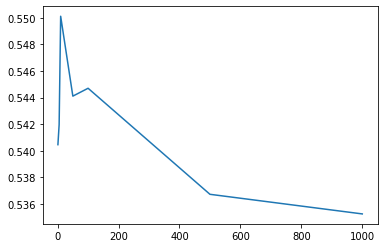

In [92]:
plt.plot([1,5,10,50,100,500,1000], np.mean(np.array(s),axis=1))

In [93]:
np.mean(np.array(s),axis=1)

array([0.54046006, 0.54196705, 0.55011404, 0.54410889, 0.54470042,
       0.53672932, 0.53525494])

In [18]:
clf = XGBClassifier(
    objective='multi:softmax',
    n_estimators=10,
    learning_rate=.3,
    max_depth=6,
    subsample=.3,
    n_jobs=6,
    colsample_bytree=.9,
    random_state=1126,
    gamma=10
)

In [19]:
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9, gamma=10,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=6, num_parallel_tree=None,
              objective='multi:softmax', random_state=1126, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.3,
              tree_method=None, validate_parameters=None, verbosity=None)

In [37]:
clf.fit(x, y)

/home/jacky/.pyenv/versions/html-3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=6, num_parallel_tree=1,
              objective='multi:softprob', random_state=1126, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
pred = clf.predict(x)

In [28]:
mat = np.zeros((3,3))
for p, a in zip(pred, y):
    mat[p, a] += 1

In [35]:
p

2

In [34]:
mat

array([[4.3701e+04, 4.3820e+03, 1.2000e+02],
       [2.5540e+03, 2.1163e+04, 4.1000e+01],
       [1.2516e+04, 6.1960e+03, 8.5800e+02]])